In [517]:
import numpy as np
import re

In [518]:
import os.path

In [519]:
class LSHtree:
    def __init__(self):

        self.left = None
        self.right = None
        self.index = None
        self.bit = None


    def print_node(self):
        print("Index :",self.index)
        print("Bit :",self.bit)
        

In [520]:
def print_tree(tree):
    if tree==None:
        return
    tree.print_node()
    print("Left Child")
    print_tree(tree.left)
    print("Right Child")
    print_tree(tree.right)

In [521]:
def get_num_nodes(tree):
    if tree == None:
        return 0
    total = 1
    total += get_num_nodes(tree.left)
    total += get_num_nodes(tree.right)
    return total

In [522]:
def get_sub_content(file_content):
    start=1
    while (file_content[start] != "{"):
        if file_content[start] == "}":
            return ("",-1,-1)
        start += 1
    
    end = start + 1
    num_left = 1
    num_right = 0
    N = len(file_content)
    while (num_left > num_right) and (end < N):
        if file_content[end] == "{":
            num_left += 1
        elif file_content[end] == "}":
            num_right += 1
        end += 1
    
    return (file_content[start:end+1], start, end)

In [523]:
def read_hash(file_content):
    tree = LSHtree()
    if len(file_content)==0:
        return None
    hash_str = re.findall("\([0,1,2],[0-9]+\)",file_content)[0]
    tree.bit = int(hash_str[1])
    tree.index = int(re.findall(",[0-9]+",hash_str)[0][1:])
    
    
    left_cont, s_l, e_l = get_sub_content(file_content)
    if len(left_cont) == 0:
        right_cont = ""
    else:
        right_cont, _, _ = get_sub_content(file_content[:s_l] + file_content[e_l+1:])
    

    tree.left = read_hash(left_cont)
    tree.right = read_hash(right_cont)
    
    return tree
    

In [524]:
def read_tree(hashfile, filename):
    content = hashfile.read()
    #print(len(content))
    if len(content)==0:
        #print("returning")
        return
    
    new_content = "{ (2,2)" + content[2:][:-1]
    #print(new_content)
    #print("----------")
    tree = read_hash(new_content)
    #print(tree)
    return tree

In [525]:
def read_all_trees(hash_dir):
    trees = []
    num_trees = 100
    start=200
    for t in range(start, start + num_trees):
        filename = hash_dir + "hashes" + str(t)
        
        if not os.path.isfile(filename):
            continue
            
        with open(filename, "r") as hashfile:
            trees.append(read_tree(hashfile, filename))
    return trees

### ImageNet

In [526]:
path = "/Users/dbeaglehole/Desktop/Research/instance_optimal_LSH/ImageNetHashes/"
hash_dirs = ["hashes_c1o2_long/"]
hash_dirs = [path + x for x in hash_dirs]
trees_list = []
for hash_dir in hash_dirs:
    trees = read_all_trees(hash_dir)
    trees = [t for t in trees if t != None]
    trees_list.append(trees)

In [527]:
len(trees_list[0])

82

#### Load Dataset

In [528]:
FRAC=80
t=125

In [529]:
datafile = '/Users/dbeaglehole/Desktop/Research/instance_optimal_LSH/image_net.npy'
dataset = np.load(datafile)
dataset = dataset[:dataset.shape[0]//FRAC,:]
dataset = (dataset >= t).astype('int')

In [530]:
num_images, dim = dataset.shape
num_images, dim 

(625, 192)

### Generate Uniform Tree

In [476]:
import random 

In [531]:
bucket_size=10

In [532]:
def hash_d(dataset, used_hashes):
    hashed_dataset = np.copy(dataset)
    for bit, index in used_hashes:
        if bit==2:
            continue
        hashed_dataset = hashed_dataset[np.nonzero(hashed_dataset[:,index] == bit)]
    return hashed_dataset

In [533]:
def generate_uniform_tree(used_hashes, dataset):
    
    hashed_dataset = hash_d(dataset, used_hashes)
    #print(hashed_dataset.shape[0])
    tree = LSHtree()
    tree.bit = used_hashes[-1][0]
    tree.index = used_hashes[-1][1]
    if hashed_dataset.shape[0] <= bucket_size:
        return tree
    
    idx = random.randint(0, dim-1)
    
    tree.left = generate_uniform_tree(used_hashes + [(1,idx)], hashed_dataset)
    tree.right = generate_uniform_tree(used_hashes + [(0,idx)], hashed_dataset)
    
    return tree
    

In [535]:
num_trees=80
uniform_trees = []
for t in range(num_trees):
    if (t%5==0):
        print("uniform tree %d/%d" % (t+1,num_trees))
    tree = generate_uniform_tree([(2,2)],dataset)
    uniform_trees.append(tree)

uniform tree 1/80
uniform tree 6/80
uniform tree 11/80
uniform tree 16/80
uniform tree 21/80
uniform tree 26/80
uniform tree 31/80
uniform tree 36/80
uniform tree 41/80
uniform tree 46/80
uniform tree 51/80
uniform tree 56/80
uniform tree 61/80
uniform tree 66/80
uniform tree 71/80
uniform tree 76/80


### Generate Queries

In [543]:
#originally r = 10
r=15

In [544]:
def rand_flip(image, dim):
    new_query = np.copy(image)
    for i in range(r):
        rand_idx = random.randint(0,dim-1)
        new_query[rand_idx] = not new_query[rand_idx]
    return new_query

In [545]:
def generate_random_queries(dataset):
    query_list = []
    queries_per_img = 50
    num_images, dim = dataset.shape
    for i in range(num_images):
        image = dataset[i]
        for j in range(queries_per_img):
            flipped_query = rand_flip(image,dim)
            query_list.append((flipped_query,i))
    return query_list

In [546]:
def flip_on_bits(image, bits):
    query = np.copy(image)
    for _, idx in bits:
        query[idx] = (not image[idx])*1
    return query

In [547]:
query_list = generate_random_queries(dataset)

### Eval Optimized

In [548]:
def eval_tree(tree, query, datapoint):
    if tree.left == None: #leaf
        return 1
    
    index = tree.left.index
    
    if query[index] == datapoint[index] == 1:
        return eval_tree(tree.left, query, datapoint)
    elif query[index] == datapoint[index] == 0:
        return eval_tree(tree.right, query, datapoint)
    else:
        return 0

### Time Random Queries

In [549]:
#./hashesLong_c1/
#./hashesLong_c1o2/
#./hashesv1_c1.5/
#./hashes_opt/
#./hashesv1_c10/
#./hashesv1_c4/

In [562]:
import time

In [567]:
time_trees_list = trees_list + [uniform_trees]

In [568]:
time_list = []
for trees in time_trees_list:
    times = []
    for q,i in query_list:
        if (t%10000==0):
            print("itr ",t)
        start = time.time()
        for tree in trees:
            if eval_tree(tree, q, dataset[i]):
                break
        end = time.time()
        times.append(end - start)
        
    time_list.append(times)

In [89]:
for times in time_list:
    print(max(times))

0.00047898292541503906
0.0010509490966796875
0.03725695610046387
0.049226999282836914
0.002685070037841797
0.003336191177368164
0.0017910003662109375
0.0011799335479736328


In [569]:
for times in time_list:
    print(sum(times)/len(times))

4.4483673095703124e-05
4.0486961364746096e-05
3.6475296020507815e-05
3.7156005859375e-05


### Compute Recall for Random Queries

In [551]:
p_success_list = []
for trees in trees_list:
    p_success = []
    t=0
    for q,i in query_list:
        if (t%10000==0):
            print("itr ",t)
        total = 0
        for tree in trees:
            succ = eval_tree(tree, q, dataset[i])
            total += succ
        p_success.append(total/len(trees))
        t+=1
    p_success_list.append(p_success)

itr  0
itr  10000
itr  20000
itr  30000


### Eval Uniform

In [552]:
p_success_uniform = []
t=0
for q,i in query_list:
    if (t%10000==0):
        print("itr ",t)
    total = 0
    for tree in uniform_trees:
        total += eval_tree(tree, q, dataset[i])
    p_success_uniform.append(total/len(uniform_trees))
    t+=1

itr  0
itr  10000
itr  20000
itr  30000


## Plotting

In [553]:
from statistics import mean

In [554]:
import matplotlib.pyplot as plt
import numpy as np

In [555]:
n_bins = 20

In [556]:
n = len(p_success)

In [557]:
m=1
sorted_opt = sorted(p_success)#[:m]
sorted_uni = sorted(p_success_uniform)#[:m]
mean(sorted_opt)/mean(sorted_uni)

0.962546535573931

In [558]:
for p_success in p_success_list:
    print(mean(p_success))
print(mean(p_success_uniform))

0.4915601951219512
0.5106872


In [559]:
order.append("Uni")

In [560]:
order = ['ρ=1', 'ρ=0.83', 'ρ=0.67', 'computed ρ', 'ρ=0.1', 'ρ=0.25']

0


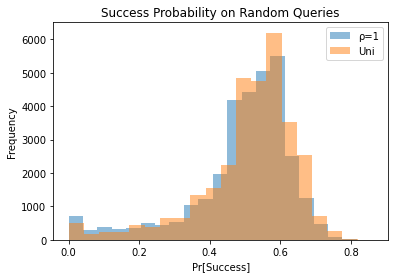

In [561]:
for i, p_success in enumerate(p_success_list):
    plt.figure()
    print(i)
    plt.hist(p_success, n_bins, alpha=0.5, label=order[i])
    plt.hist(p_success_uniform, n_bins, alpha=0.5, label='Uni')
    plt.legend(loc='upper right')
    plt.title("Success Probability on Random Queries")
    plt.xlabel("Pr[Success]")
    plt.ylabel("Frequency")
    #plt.savefig("./comparison" + order[i] + ".png")
    plt.show()